# SSM non parametrique 

## Simple

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [5]:

class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self,X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]  # check dimension

        # np.random.randint returns ints from [low, high) !
        idx = np.random.randint(self.X.shape[0], size=shape[0])

        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```

    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):

        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(
            0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     # initializer='ones',
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):
        C = tf.expand_dims(self.centers, -1)  # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))  # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

Epoch 1/100
289/289 [==============================] - 1s 2ms/step - loss: 35203.5898
Epoch 2/100
289/289 [==============================] - 0s 2ms/step - loss: 34089.6172
Epoch 3/100
289/289 [==============================] - 0s 2ms/step - loss: 33027.1055
Epoch 4/100
289/289 [==============================] - 0s 2ms/step - loss: 10170.6719
Epoch 5/100
289/289 [==============================] - 0s 1ms/step - loss: 159.4999
Epoch 6/100
289/289 [==============================] - 0s 1ms/step - loss: 134.2179
Epoch 7/100
289/289 [==============================] - 0s 1ms/step - loss: 116.9192
Epoch 8/100
289/289 [==============================] - 0s 1ms/step - loss: 102.7197
Epoch 9/100
289/289 [==============================] - 0s 1ms/step - loss: 89.0325
Epoch 10/100
289/289 [==============================] - 0s 1ms/step - loss: 75.6821
Epoch 11/100
289/289 [==============================] - 0s 1ms/step - loss: 64.4675
Epoch 12/100
289/289 [==============================] - 0s 2ms/step -

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


578/578 [==============================] - 1s 894us/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


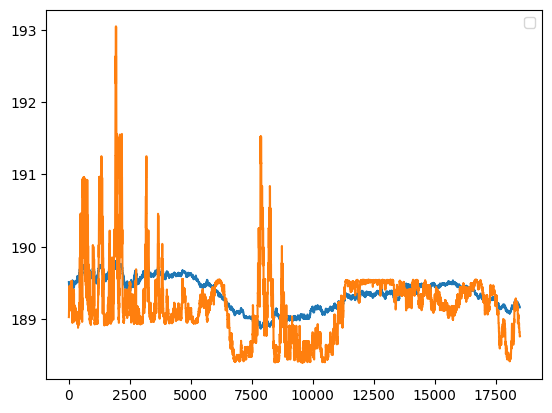

In [7]:

# Generate some random data for testing
np.random.seed(23)
scaler = MinMaxScaler()
dff = pd.read_csv(r"C:\Users\collo\Downloads\Appl_data.csv",sep=";",decimal=',')[["Date","price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)

x_train = dff.to_numpy()[:-1]
y_train = dff.prices.to_numpy().reshape(-1,1)[1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build a simple model
model = Sequential()
#model.add(tf.keras.layers.Input(shape=(2,)))
#model.add(Dense(10,activation=tf.keras.activations.relu))
model.add(RBFLayer(output_dim=10, initializer=rbf_initializer, betas=1.0, input_shape=(4,)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=64)


# Optionally, you can save the model for later use
model.save('rbf_model.h5')
pred = model.predict(x_train)

plt.plot(y_train)
plt.plot(pred)

plt.legend()

Le modèle parait pas mal mais il y a un overfitting de zinzin

## Mise à jour

### Test 1 : Normaliser les données

In [ ]:

# Generate some random data for testing
np.random.seed(23)
scaler = MinMaxScaler()
dff = pd.read_csv(r"C:\Users\collo\Downloads\Appl_data.csv",sep=";",decimal=',')[["Date","price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)

x_train = dff.to_numpy()[:-1]
y_train = dff.prices.to_numpy().reshape(-1,1)[1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build a simple model
model = Sequential()
#model.add(tf.keras.layers.Input(shape=(2,)))
#model.add(Dense(10,activation=tf.keras.activations.relu))
model.add(RBFLayer(output_dim=10, initializer=rbf_initializer, betas=1.0, input_shape=(4,)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=64)


# Optionally, you can save the model for later use
model.save('rbf_model_1.h5')
pred = model.predict(x_train)

plt.plot(y_train)
plt.plot(pred)

plt.legend()

### Test 2 - eviter l'overfitting

Epoch 1/100
203/203 [==============================] - 2s 4ms/step - loss: 34843.5820 - val_loss: 34296.4844
Epoch 2/100
203/203 [==============================] - 1s 3ms/step - loss: 33922.7031 - val_loss: 33451.8945
Epoch 3/100
203/203 [==============================] - 1s 3ms/step - loss: 33190.9219 - val_loss: 32784.1211
Epoch 4/100
203/203 [==============================] - 1s 3ms/step - loss: 32544.8027 - val_loss: 32166.9512
Epoch 5/100
203/203 [==============================] - 1s 3ms/step - loss: 31912.7363 - val_loss: 31559.8652
Epoch 6/100
203/203 [==============================] - 1s 3ms/step - loss: 25161.8418 - val_loss: 76.8338
Epoch 7/100
203/203 [==============================] - 1s 3ms/step - loss: 46.6448 - val_loss: 71.9301
Epoch 8/100
203/203 [==============================] - 1s 3ms/step - loss: 37.9534 - val_loss: 71.5732
Epoch 9/100
203/203 [==============================] - 1s 3ms/step - loss: 37.6349 - val_loss: 71.7485
Epoch 10/100
203/203 [==================

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


578/578 [==============================] - 1s 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


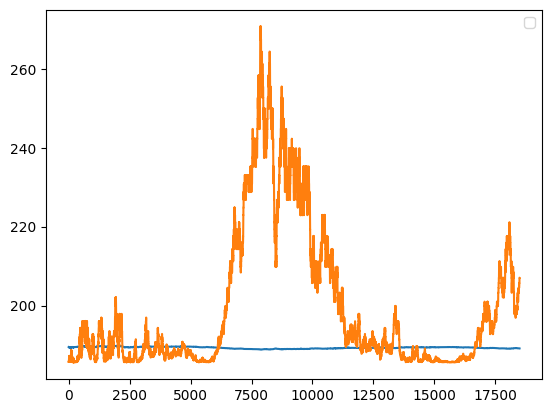

In [8]:

# Generate some random data for testing
np.random.seed(23)
scaler = MinMaxScaler()
dff = pd.read_csv(r"C:\Users\collo\Downloads\Appl_data.csv",sep=";",decimal=',')[["Date","price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)

x_train = dff.to_numpy()[:-1]
y_train = dff.prices.to_numpy().reshape(-1,1)[1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build a simple model
model = Sequential()
#model.add(tf.keras.layers.Input(shape=(2,)))
#model.add(Dense(10,activation=tf.keras.activations.relu))
model.add(RBFLayer(output_dim=10, initializer=rbf_initializer, betas=1.0, input_shape=(4,)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.3,
    batch_size=64,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)


# Optionally, you can save the model for later use
model.save('rbf_model_2.h5')
pred = model.predict(x_train)

plt.plot(y_train)
plt.plot(pred)

plt.legend()

### Test 3 - augmenter le nombre de neurone par couches

Epoch 1/25
289/289 [==============================] - 4s 6ms/step - loss: 30656.9316
Epoch 2/25
289/289 [==============================] - 2s 6ms/step - loss: 21976.8633
Epoch 3/25
289/289 [==============================] - 2s 6ms/step - loss: 14579.7676
Epoch 4/25
289/289 [==============================] - 2s 6ms/step - loss: 1026.8888
Epoch 5/25
289/289 [==============================] - 2s 5ms/step - loss: 25.7714
Epoch 6/25
289/289 [==============================] - 2s 6ms/step - loss: 23.4844
Epoch 7/25
289/289 [==============================] - 2s 6ms/step - loss: 21.8210
Epoch 8/25
289/289 [==============================] - 2s 6ms/step - loss: 20.1152
Epoch 9/25
289/289 [==============================] - 2s 5ms/step - loss: 18.2155
Epoch 10/25
289/289 [==============================] - 1s 5ms/step - loss: 16.0459
Epoch 11/25
289/289 [==============================] - 2s 6ms/step - loss: 13.7213
Epoch 12/25
289/289 [==============================] - 2s 7ms/step - loss: 11.5266
Ep

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


578/578 [==============================] - 3s 5ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


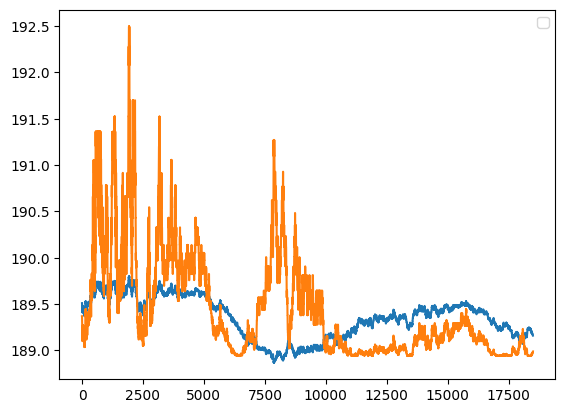

In [21]:

# Generate some random data for testing
np.random.seed(23)
scaler = MinMaxScaler()
dff = pd.read_csv(r"C:\Users\collo\Downloads\Appl_data.csv",sep=";",decimal=',')[["Date","price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)

x_train = dff.to_numpy()[:-1]
y_train = dff.prices.to_numpy().reshape(-1,1)[1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build a simple model
model = Sequential()
#model.add(tf.keras.layers.Input(shape=(2,)))
#model.add(Dense(10,activation=tf.keras.activations.relu))
model.add(RBFLayer(output_dim=100, initializer=rbf_initializer, betas=1.0, input_shape=(4,)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size=64)


# Optionally, you can save the model for later use
model.save('rbf_model.h5')
pred = model.predict(x_train)

plt.plot(y_train)
plt.plot(pred)

plt.legend()

pour 100 neurones : 100 epoch - loss : 0.0123   -> TROP FIDELE
                                       0.0130
                    50 epoch  - loss : 0.0225   -> TROP FIDELE
                                       0.0176
                    10 epoch  - loss : 15.9658  -> PAS ASSEZ
                                       15.9249
                    20 epoch  - loss : 2.8253   -> PAS DINGUE
                                       3.5893
                    30 epoch  - loss : 0.0331   -> TROP FIDELE
                                       0.0389
                    25 epoch  - loss : 0.7080  -> BOF
                                       0.5523
                                
                                    
                    
                                       

## Optimisation

Epoch 1/100
203/203 [==============================] - 2s 6ms/step - loss: 35815.1406 - val_loss: 35778.3398
Epoch 2/100
203/203 [==============================] - 1s 4ms/step - loss: 35738.4180 - val_loss: 35701.6641
Epoch 3/100
203/203 [==============================] - 1s 4ms/step - loss: 35661.7852 - val_loss: 35625.0781
Epoch 4/100
203/203 [==============================] - 1s 4ms/step - loss: 35585.2617 - val_loss: 35548.6172
Epoch 5/100
203/203 [==============================] - 1s 4ms/step - loss: 35508.8516 - val_loss: 35472.2695
Epoch 6/100
203/203 [==============================] - 1s 4ms/step - loss: 35432.5664 - val_loss: 35396.0352
Epoch 7/100
203/203 [==============================] - 1s 5ms/step - loss: 35356.3828 - val_loss: 35319.8789
Epoch 8/100
203/203 [==============================] - 1s 5ms/step - loss: 35280.2891 - val_loss: 35243.8672
Epoch 9/100
203/203 [==============================] - 1s 4ms/step - loss: 35204.3164 - val_loss: 35167.9258
Epoch 10/100
203/20

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


578/578 [==============================] - 1s 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


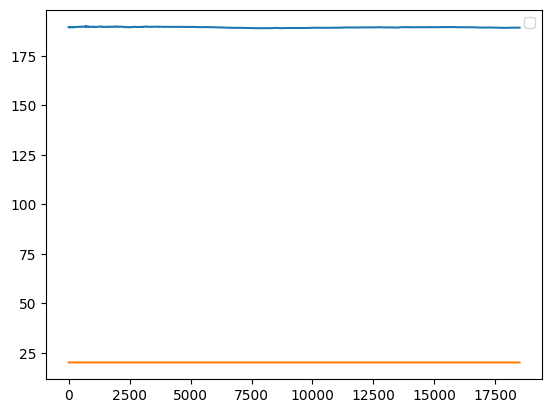

In [49]:
# Generate some random data for testing
np.random.seed(23)
scaler = MinMaxScaler()
dff = pd.read_csv(r"C:\Users\collo\Downloads\Appl_data.csv",sep=";",decimal=',')[["Date","price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)

x_train = dff.to_numpy()[:-1]
y_train = dff.prices.to_numpy().reshape(-1,1)[1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build a simple model
model = Sequential()
#model.add(tf.keras.layers.Input(shape=(2,)))
#model.add(Dense(1,activation=tf.keras.activations.relu))
model.add(RBFLayer(output_dim=100, initializer=rbf_initializer, betas=1.0, input_shape=(4,)))
model.add(Dense(1,activation=tf.keras.activations.relu))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.3,
    batch_size=64,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)


# Optionally, you can save the model for later use
model.save('rbf_model_4.h5')
pred = model.predict(x_train)

plt.plot(y_train)
plt.plot(pred)

plt.legend()

epoch = 100
RBF - 100
2 x 1 Layer
run 1 : loss: 28647.1660 - val_loss: 28614.4336
run 2 : loss: 2.5412e-04 - val_loss: 3.5123e-04
run 3 : loss: 28647.1660 - val_loss: 28614.4336